---

## **OPTIMIZACIÓN DEL CONSUMO ENERGÉTICO:**
## **ENTRENAMIENTO DEL AGENTE EN DEEP Q-LEARNING**

---

**Autor:** Sergio Bolívar Gómez

**Fecha de creación:** 8 de mayo de 2023.

**Última modificación:** 7 de julio de 2023.


## **OBJETIVO**

El objetivo de este notebook es diseñar/programar un esquema de aprendizaje por refuerzo basado en Deep Q-Learning. En particular, se crea el entorno (que es el modelo de ML: se escoge el convolucional-recurrente por ser el que mejor resultados proporciona) y el agente (que es una Deep Q-Network). Un estado viene determinado por un patrón de calentamiento (5 series temporales, de 200 observaciones cada una). El espacio de acciones de define discretizando el espacio de estados con una granularidad de 20 puntos (cada 20 puntos, se sube/baja la potencia un tanto por ciento). A falta de que GSW defina una estrategia de trabajo, como prueba de concepto se utiliza como estado inicial la media de los patrones de calentamiento de las palanquillas de resulfurado (18 palanquillas en total). Igualmente, a falta de un criterio mejor, el perfil de temperaturas objetivo se establece como la media de los perfiles de temperaturas de las palanquillas de resulfurado simulados con el modelo de elementos finitos.

## **IMPORTACIÓN DE LIBRERÍAS**

Importamos algunas de las librerías que vamos a utilizar en este notebook:


In [19]:
import os # para interacturar con el sistema
import pandas as pd # para manejar DataFrames
import numpy as np # para manejar arrays y hacer operaciones sobre ellos
import matplotlib.pyplot as plt # para hacer gráficas
import seaborn as sns # para hacer gráficas más avanzadas
import math # para hacer algunas operaciones
import glob # para aglutinar archivos
import copy # para hacer copias de objetos de Python
import pickle # para guardar diccionario de Python en ficheros
import random # para hacer elecciones aleatorias y establecer semillas
import time # para llevar un registro del tiempo de ejecución

from scipy.interpolate import interp1d # para remuestrear señal
from datetime import datetime # para formatear fechas
from tqdm import tqdm # para hacer bucles más elegantes y ver su progreso
from collections import deque

In [20]:
# Para usar la fuente de LaTex en los plots
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']

## **IMPORTACIÓN Y PREPROCESADO DE LOS DATOS**

En primer lugar, construimos una lista que contiene los identificadores de las palanquillas simuladas.


In [21]:
output_files_path = "/home/bolivars/Escritorio/data/preprocessed/files-to-ml/outputs" # CHANGEME: esto es un path a una carpeta con los inputs/outputs de las palanquillas simuladas

simul_billets = [] # esta lista contendrá los identificadores de las palanquillas que se han simulado

for filename in os.listdir(output_files_path): # recorremos los archivos del path anterior
    if filename.startswith("resultados_caso_estudio_palanquilla_") and filename.endswith(".csv"):
        number = filename.split("_")[-1].split(".")[0] # extraemos el identificador de la palanquilla
        simul_billets.append(number) # añadimos el identificador de la palanquilla a la lista

simul_billets.sort() # ordenamos la lista

In [22]:
print(f"NÚMERO DE PALANQUILLAS SIMULADAS: {len(simul_billets)}")

NÚMERO DE PALANQUILLAS SIMULADAS: 217


En segundo lugar, creamos un diccionario con información sobre las palanquillas simuladas (longitud, diámetro, hilo, material, calidad/familia...).

In [23]:
info_palanquillas_db = {} # este diccionario contendrá la información relativa a las palanquillas; siendo sus keys los IDs correspondientes

long_path = "/home/bolivars/Escritorio/data/raw/additional-info"  # CHANGEME: path que lleva a la información de las palanquillas

file_pattern = os.path.join(long_path, "long_*.csv") # patrón útil para localizar los ficheros con información sobre las palanquillas
long_files = glob.glob(file_pattern) # lista con todos los ficheros proporcionados por GSW

data_to_store = ["long_punta", "long_cola", "diametro", "hilo", "material", "calidad"] # variables que representan la información que queremos almacenar

for long_data_file in long_files: # recorremos los ficheros proporcionados por GSW

    original_data = pd.read_csv(long_data_file, sep = ',', decimal = ".", # leemos los datos originales desde el CSV
                                usecols=lambda col: col != "Unnamed: 0") # eliminamos la variable unnamed (basura)
    
    data_grouped_by_bulto = original_data.groupby('bulto') # agrupamos los datos según el bulto (identificador de la palanquilla)

    for name, group in data_grouped_by_bulto:

        palanquilla_info = {k: pd.DataFrame(group)[k].values[0] for k in data_to_store} # diccionario que contendrá la información especificada en la lista 'info_to_store'  

        info_palanquillas_db[name] = palanquilla_info # la key es el bulto de la palanquilla (identificador); el value el diccionario con toda la información

Finalmente, creamos un diccionario que contiene toda la información relativa a la simulaciones (inputs, outputs, información sobre las palanquillas simuladas...).

In [24]:
billets_db = {} # creamos un diccionario que contenga toda la información relativa a las simulaciones (inputs/outputs ANSYS + ML)

for billet in simul_billets:

    input_path = f"/home/bolivars/Escritorio/data/preprocessed/files-to-ml/inputs/caso_estudio_palanquilla_{billet}.csv" # CHANGEME: path a los inputs
    output_path = f"/home/bolivars/Escritorio/data/preprocessed/files-to-ml/outputs/resultados_caso_estudio_palanquilla_{billet}.csv" # CHANGEME: path a los outputs

    info_to_store = ["inputs_ansys", "inputs_ML", "outputs_ansys", "outputs_ML"] # información que queremos almacenar

    billet_temp = {k: None for k in info_to_store} # diccionario que contendrá la información especificada en la lista 'info_to_store'

    ## LECTURA DE INPUTS ##
    billet_temp["inputs_ansys"] = pd.read_csv(input_path, sep = ',', decimal = ".") # leemos los inputs de ANSYS desde el CSV    
    billet_temp["inputs_ML"] = pd.read_csv(input_path, sep = ',', decimal = ".").drop_duplicates(subset=['posicion'], keep='first') # eliminamos los datos artificiales añadidos hasta llegar a tamaño 200 (fijado para la simulación)
    
    ## LECTURA DE OUTPUTS ##
    billet_temp["outputs_ansys"] = pd.read_csv(output_path, sep = ',', decimal = ".")

    # INTERPOLO LOS OUTPUTS DE ANSYS AL TAMAÑO DEL INPUT (SIN AÑADIR LOS CEROS)
    new_size = billet_temp["inputs_ML"].shape[0] # tamaño original del input (sin los 0s añadidos de manera artificial)
    pos_temp = billet_temp["outputs_ansys"][["posicion", "temperatura"]].values # valores de posición y temperatura
    new_indices = np.linspace(0, len(pos_temp)-1, new_size) # nuevos índices
    resampled_pos_temp = np.zeros((new_size, 2))

    resampled_pos_temp[:, 0] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 0]) # interpolamos posición
    resampled_pos_temp[:, 1] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 1]) # interpolamos temperatura

    billet_temp["outputs_ML"] = pd.DataFrame({'posicion': resampled_pos_temp[:,0], 'temperatura': resampled_pos_temp[:,1]}) # guardamos los outputs interpolados

    # REDUZCO LA DIMENSIÓN DE LOS OUTPUTS DE ANSYS
    new_size = 50 # tamaño del vector reducido de outputs
    pos_temp = billet_temp["outputs_ansys"][["posicion", "temperatura"]].values # valores de posición y temperatura
    new_indices = np.linspace(0, len(pos_temp)-1, new_size) # nuevos índices en el sistema reducido
    resampled_pos_temp = np.zeros((new_size, 2))

    resampled_pos_temp[:, 0] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 0]) # interpolamos posición
    resampled_pos_temp[:, 1] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 1]) # interpolamos temperatura

    billet_temp["outputs_ML_reduced"] = pd.DataFrame({'posicion': resampled_pos_temp[:,0], 'temperatura': resampled_pos_temp[:,1]}) # guardamos los outputs reducidos

    for item in data_to_store: # añado al diccionario global la información adicional sobre la palanquilla (longitud, material, hilo...)
        billet_temp[item] = info_palanquillas_db[int(billet)][item]
        
    # GUARDADO DE DATOS
    billets_db[billet] = billet_temp # asociamos cada palanquilla con sus datos correspondientes
    
else:
    position_index = billets_db[billet]["outputs_ML_reduced"]["posicion"].copy() # nuevo vector de posición interpolado al tamaño de 'new_size' (para hacer gráficas)

## **CÁLCULO DEL CONSUMO ENERGÉTICO**

En esta sección se define una función para calcular el consumo energético correspondiente a los diferentes patrones de calentamiento que se aplican sobre las palanquillas. 

OJO: se asume que cada potencia instantánea se aplica durante 1 segundo (aunque realmente es un poco, muy poco, más). Esto nos permite dar una estimación del consumo energético.

In [25]:
def compute_energy_consumption(inputs_ansys):
    """
    Calcula el consumo de energía asociado a un patrón de calentamiento.

    INPUTS:
    inputs_ansys (DataFrame): un DataFrame que contiene el patrón de calentamiento (series temporales del avance de la palanquilla y las potencias
                              instantáneas de los cuatro inductores del horno) cuyo consumo energético quiere calcularse.

    OUTPUTS:
    float: el consumo de energía total en kilovatios-hora (Kwh).

    """
    data = inputs_ansys.drop_duplicates(subset=['posicion'], keep='first').copy() # eliminamos los datos artificiales añadidos hasta llegar a tamaño 200

    data["avance_temp"] = data["avance"]/data["velocidad"]
    data["inst_energy_consumption"] = 1/3600*data["avance_temp"]*(data["IND_1"] + data["IND_2"] + data["IND_3"] + data["IND_4"])

    energy_consumption = data["inst_energy_consumption"].sum()

    return energy_consumption # in Kwh

In [26]:
energy_consumption_per_billet = {} # diccionario que contendrá el consumo energético asociado a cada palanquilla (key: ID; value: consumo energético)

for billet in list(billets_db.keys())[11:29]: # recorremos exclusivamente la familia de resulfurados (para la que se calibra el modelo)
    energy_consumption_per_billet[billet] = compute_energy_consumption(billets_db[billet]["inputs_ansys"])

energy_consumption_per_billet_sorted = dict(sorted(energy_consumption_per_billet.items(), key=lambda x: x[1]))

energy_consumption_per_billet_sorted

{'6211358': 11.608222222222222,
 '6211344': 11.745053002042813,
 '6211346': 13.907280551535617,
 '6211345': 14.242555555555555,
 '6211343': 14.594388487282465,
 '6211347': 15.437238095238087,
 '6211349': 15.726611111111112,
 '6211350': 15.729440072639225,
 '6211351': 15.931511355575388,
 '6211352': 15.944625000000016,
 '6211348': 16.017576378839046,
 '6211357': 16.456517611271213,
 '6211342': 16.499874243641226,
 '6211356': 16.653256313738055,
 '6211355': 17.035127526550184,
 '6211341': 17.080698689998073,
 '6211353': 17.323074656949125,
 '6211354': 17.608968253968264}

Representamos los patrones de calentamiento que llevan asociados un mayor y un menor consumo energético, respectivamente.

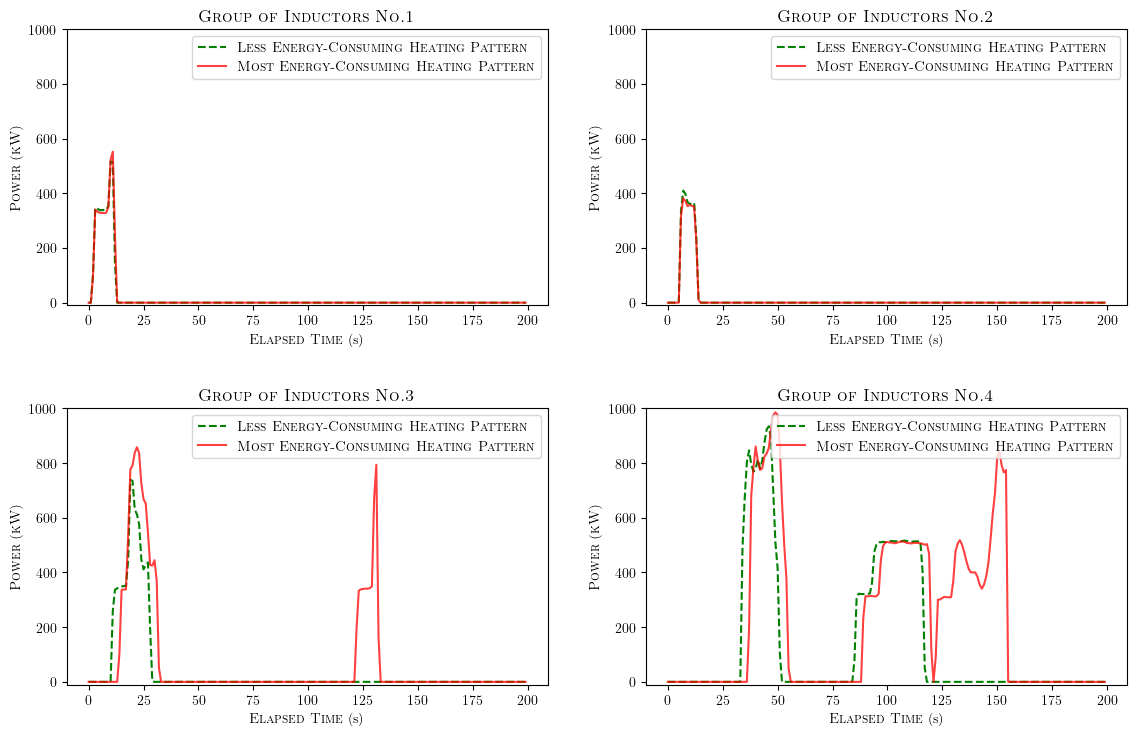

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

lowest_energy = billets_db["6211358"]["inputs_ansys"].copy().drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1).to_numpy().ravel()
lowest_energy = lowest_energy.reshape(200, 5)

highest_energy = billets_db["6211354"]["inputs_ansys"].copy().drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1).to_numpy().ravel()
highest_energy = highest_energy.reshape(200, 5)

# Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
axes[0, 0].plot(lowest_energy[:, 1], label=r"\textsc{Less Energy-Consuming Heating Pattern}", color="green", linestyle="--")
axes[0, 0].plot(highest_energy[:, 1], label=r"\textsc{Most Energy-Consuming Heating Pattern}", color="red", alpha=0.75)
axes[0, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[0, 0].set_ylabel(r"\textsc{Power (kW)}")
axes[0, 0].set_title(r"\textsc{Group of Inductors No.1}")
axes[0, 0].legend(loc="upper right")
axes[0, 0].set_ylim(-10, 1000)

# Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
axes[0, 1].plot(lowest_energy[:, 2], label=r"\textsc{Less Energy-Consuming Heating Pattern}", color="green", linestyle="--")
axes[0, 1].plot(highest_energy[:, 2], label=r"\textsc{Most Energy-Consuming Heating Pattern}", color="red", alpha=0.75)
axes[0, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[0, 1].set_ylabel(r"\textsc{Power (kW)}")
axes[0, 1].set_title(r"\textsc{Group of Inductors No.2}")
axes[0, 1].legend(loc="upper right")
axes[0, 1].set_ylim(-10, 1000)


# Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
axes[1, 0].plot(lowest_energy[:, 3], label=r"\textsc{Less Energy-Consuming Heating Pattern}", color="green", linestyle="--")
axes[1, 0].plot(highest_energy[:, 3], label=r"\textsc{Most Energy-Consuming Heating Pattern}", color="red", alpha=0.75)
axes[1, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[1, 0].set_ylabel(r"\textsc{Power (kW)}")
axes[1, 0].set_title(r"\textsc{Group of Inductors No.3}")
axes[1, 0].legend(loc="upper right")
axes[1, 0].set_ylim(-10, 1000)


# Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
axes[1, 1].plot(lowest_energy[:, 4], label=r"\textsc{Less Energy-Consuming Heating Pattern}", color="green", linestyle="--")
axes[1, 1].plot(highest_energy[:, 4], label=r"\textsc{Most Energy-Consuming Heating Pattern}", color="red", alpha=0.75)
axes[1, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[1, 1].set_ylabel(r"\textsc{Power (kW)}")
axes[1, 1].set_title(r"\textsc{Group of Inductors No.4}")
axes[1, 1].legend(loc="upper right")
axes[1, 1].set_ylim(-10, 1000)


plt.tight_layout(pad=3.0)
plt.show()

## **PREPARATIVOS PARA LA NORMALIZACIÓN**

Hay que tener en cuenta que los modelos de ML han sido entrados para datos normalizados, por lo que hay que recuperar los valores máximos y mínimos de cada variable en el conjunto de entrenamiento para poder normalizar los patrones de calentamiento utilizando el criterio min-max.

In [28]:
random.seed(2023) # reproducibilidad
billets_test = random.sample(simul_billets, 17) # escogemos 17 palanquillas aleatoriamente para construir conjunto de test
billets_train = set(simul_billets) - set(billets_test) # el resto forma el conjunto de entrenamiento

In [29]:
advance = [] # lista que contendrá todos los valores del avance
power_inductor_g1 = [] # lista que contendrá todos los valores de la potencia del primer grupo de inductores
power_inductor_g2 = [] # lista que contendrá todos los valores de la potencia del segundo grupo de inductores
power_inductor_g3 = [] # lista que contendrá todos los valores de la potencia del tercer grupo de inductores
power_inductor_g4 = [] # lista que contendrá todos los valores de la potencia del cuarto grupo de inductores

for billet in billets_train:

    input_data = billets_db[billet]["inputs_ansys"].copy()
    input_data = input_data.drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1) 

    advance.extend(list(input_data["avance"].values))
    power_inductor_g1.extend(list(input_data["IND_1"].values))
    power_inductor_g2.extend(list(input_data["IND_2"].values))
    power_inductor_g3.extend(list(input_data["IND_3"].values))
    power_inductor_g4.extend(list(input_data["IND_4"].values))

else:

    min_advance = min(advance) # valor mínimo del avance
    max_advance = max(advance) # valor máximo del avance

    min_power_inductor_g1 = min(power_inductor_g1) # valor mínimo de la potencia del primer grupo de inductores
    max_power_inductor_g1 = max(power_inductor_g1) # valor máximo de la potencia del primer grupo de inductores

    min_power_inductor_g2 = min(power_inductor_g2) # valor mínimo de la potencia del segundo grupo de inductores
    max_power_inductor_g2 = max(power_inductor_g2) # valor máximo de la potencia del segundo grupo de inductores

    min_power_inductor_g3 = min(power_inductor_g3) # valor mínimo de la potencia del tercer grupo de inductores
    max_power_inductor_g3 = max(power_inductor_g3) # valor máximo de la potencia del tercer grupo de inductores

    min_power_inductor_g4 = min(power_inductor_g4) # valor mínimo de la potencia del cuarto grupo de inductores
    max_power_inductor_g4 = max(power_inductor_g4) # valor máximo de la potencia del cuarto grupo de inductores

## **REINFORCEMENT LEARNING PARA OPTIMIZAR EL CONSUMO ENERGÉTICO UTILIZANDO DEEP Q-LEARNING**

Conectamos la GPU para agilizar el proceso de entrenamiento de las redes neuronales...

In [30]:
import tensorflow as tf
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if len(tf.config.list_physical_devices('GPU')):
    print(f"LA GPU SE HA CONECTADO CORRECTAMENTE. HAY {len(tf.config.list_physical_devices('GPU'))} DISPONIBLE :)")

Importamos algunas librerías útiles para el entrenamiento...

In [31]:
from tensorflow import keras # importamos Keras
from tensorflow.keras.models import Sequential # importamos el modelo secuencial (otra opción sería usar uno funcional)
from tensorflow.keras.layers import * # importamos todas las capas de Keras
from tensorflow.keras.losses import MeanSquaredError # importamos algunas funciones de pérdida
from tensorflow.keras.optimizers import Adam, RMSprop # importamos algunos optimizadores
from tensorflow.keras.metrics import RootMeanSquaredError # importamos algunas métricas
from tensorflow.keras import regularizers # importamos regularizadores para evitar overfitting
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # importamos los callbacks para el modelo
from tensorflow.keras import initializers

#### **ESTADO INICIAL**

In [32]:
##################
# ESTADO INICIAL #
##################

# En esta primera aproximación, el INITIAL STATE (el punto de partida a partir del cual tomar acciones) será el patrón de calentamiento
# medio de las palanquillas de resulfurado (ID 6211341-6211358), evitando así sesgos. Para definirlo, inicializo un estado inicial (el 
# patrón de calentamiento) de una palanquilla cualquiera y lo multiplico por cero (así mantengo la estructura correcta). Una vez hecho 
# esto, sumo todos los patrones y divido por el número total de palanquillas de resulfurado, que son 18.

INITIAL_STATE = billets_db["6211341"]["inputs_ansys"].copy().drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1).to_numpy().ravel() # estado inciial arbitrario

INITIAL_STATE = 0*INITIAL_STATE # lo pongo a cero, manteniendo estructura

for billet in list(billets_db.keys())[11:29]:
    INITIAL_STATE += billets_db[billet]["inputs_ansys"].copy().drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1).to_numpy().ravel()

INITIAL_STATE = INITIAL_STATE/len(list(billets_db.keys())[11:29])

INITIAL_STATE_BACKUP = INITIAL_STATE.copy()

STATES_SIZE = INITIAL_STATE.shape # tamaño de los estados

Representamos gráficamente el estado inicial, que se recuerda es el patrón de calentamiento medio de las palanquillas pertenecientes a la familia de resulfurados (ID 6211341-6211358)...

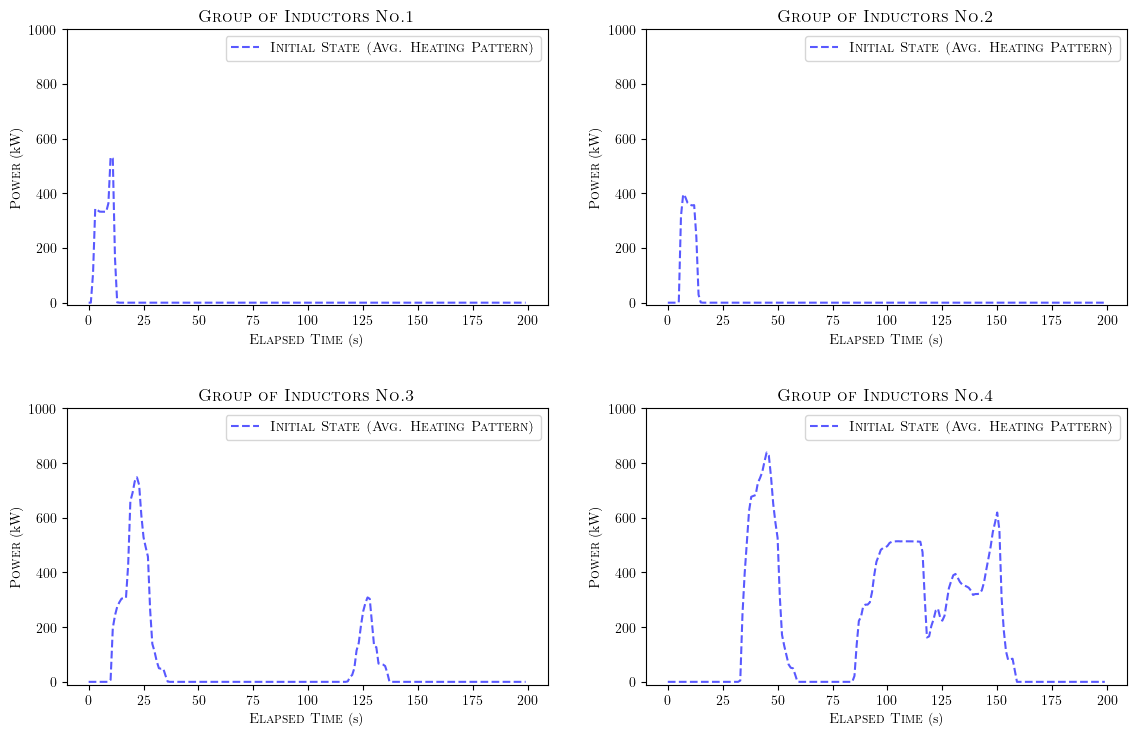

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

initial_state = INITIAL_STATE.reshape(200,5)

# Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
axes[0, 0].plot(initial_state[:, 1], label=r"\textsc{Initial State (Avg. Heating Pattern)}", color="blue", linestyle="--", alpha = 0.65)
axes[0, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[0, 0].set_ylabel(r"\textsc{Power} (kW)")
axes[0, 0].set_title(r"\textsc{Group of Inductors No.1}")
axes[0, 0].legend(loc="upper right")
axes[0, 0].set_ylim(-10, 1000) 

# Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
axes[0, 1].plot(initial_state[:, 2], label=r"\textsc{Initial State (Avg. Heating Pattern)}", color="blue", linestyle="--", alpha = 0.65)
axes[0, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[0, 1].set_ylabel(r"\textsc{Power} (kW)")
axes[0, 1].set_title(r"\textsc{Group of Inductors No.2}")
axes[0, 1].legend(loc="upper right")
axes[0, 1].set_ylim(-10, 1000) 

# Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
axes[1, 0].plot(initial_state[:, 3], label=r"\textsc{Initial State (Avg. Heating Pattern)}", color="blue", linestyle="--", alpha = 0.65)
axes[1, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[1, 0].set_ylabel(r"\textsc{Power} (kW)")
axes[1, 0].set_title(r"\textsc{Group of Inductors No.3}")
axes[1, 0].legend(loc="upper right")
axes[1, 0].set_ylim(-10, 1000) 

# Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
axes[1, 1].plot(initial_state[:, 4], label=r"\textsc{Initial State (Avg. Heating Pattern)}", color="blue", linestyle="--", alpha = 0.65)
axes[1, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[1, 1].set_ylabel(r"\textsc{Power} (kW)")
axes[1, 1].set_title(r"\textsc{Group of Inductors No.4}")
axes[1, 1].legend(loc="upper right")
axes[1, 1].set_ylim(-10, 1000)  

plt.tight_layout(pad=3.0) 
plt.show()

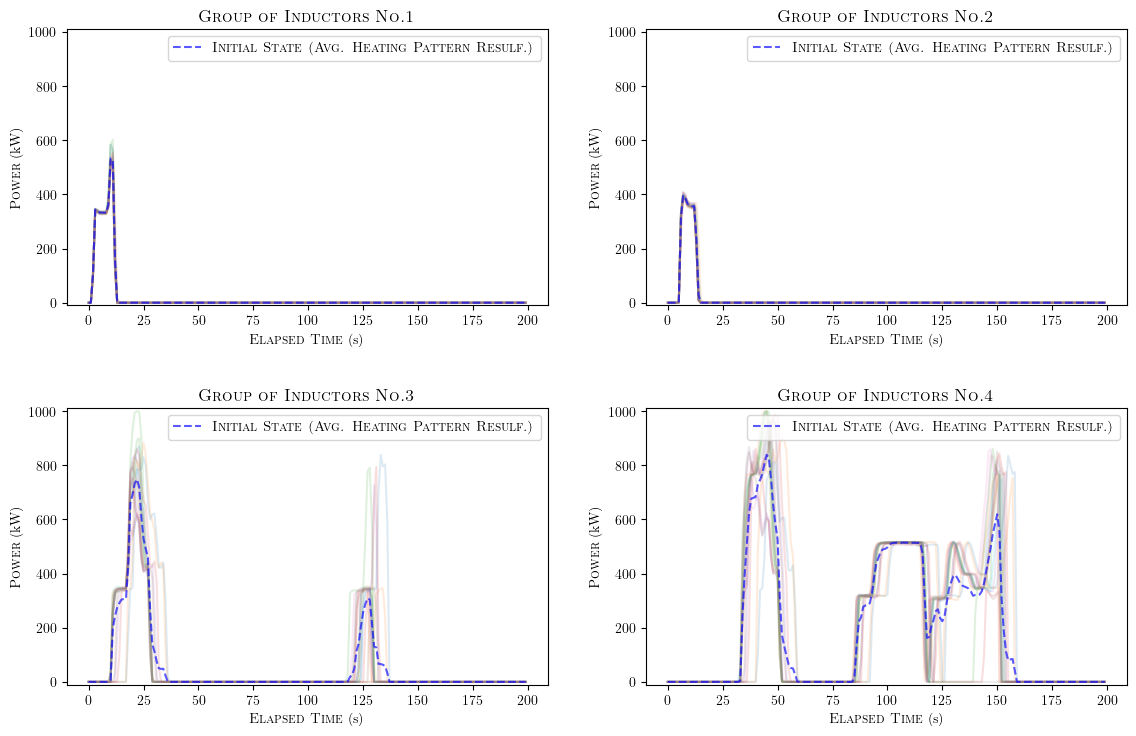

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


for billet in list(billets_db.keys())[11:29]:

    initial_state = billets_db[billet]["inputs_ansys"].copy().drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1).to_numpy().ravel().reshape(200,5)

    # Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
    axes[0, 0].plot(initial_state[:, 1], label=r"\textsc{Initial State (Avg. Heating Pattern)}", alpha = 0.15)
    axes[0, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
    axes[0, 0].set_ylabel(r"\textsc{Power} (kW)")
    axes[0, 0].set_title(r"\textsc{Group of Inductors No.1}")
    axes[0, 0].set_ylim(-10, 1000) 

    # Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
    axes[0, 1].plot(initial_state[:, 2], label=r"\textsc{Initial State (Avg. Heating Pattern)}", alpha = 0.15)
    axes[0, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
    axes[0, 1].set_ylabel(r"\textsc{Power} (kW)")
    axes[0, 1].set_title(r"\textsc{Group of Inductors No.2}")
    axes[0, 1].set_ylim(-10, 1000) 

    # Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
    axes[1, 0].plot(initial_state[:, 3], label=r"\textsc{Initial State (Avg. Heating Pattern)}", alpha = 0.15)
    axes[1, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
    axes[1, 0].set_ylabel(r"\textsc{Power} (kW)")
    axes[1, 0].set_title(r"\textsc{Group of Inductors No.3}")
    axes[1, 0].set_ylim(-10, 1000) 

    # Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
    axes[1, 1].plot(initial_state[:, 4], label=r"\textsc{Initial State (Avg. Heating Pattern)}", alpha = 0.15)
    axes[1, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
    axes[1, 1].set_ylabel(r"\textsc{Power} (kW)")
    axes[1, 1].set_title(r"\textsc{Group of Inductors No.4}")
    axes[1, 1].set_ylim(-10, 1000) 


initial_state = INITIAL_STATE.reshape(200,5).copy()

# Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
axes[0, 0].plot(initial_state[:, 1], label=r"\textsc{Initial State (Avg. Heating Pattern Resulf.)}", color="blue", linestyle="--", alpha = 0.65)
axes[0, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[0, 0].set_ylabel(r"\textsc{Power} (kW)")
axes[0, 0].set_title(r"\textsc{Group of Inductors No.1}")
axes[0, 0].set_ylim(-10, 1010) 

# Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
axes[0, 1].plot(initial_state[:, 2], label=r"\textsc{Initial State (Avg. Heating Pattern Resulf.)}", color="blue", linestyle="--", alpha = 0.65)
axes[0, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[0, 1].set_ylabel(r"\textsc{Power} (kW)")
axes[0, 1].set_title(r"\textsc{Group of Inductors No.2}")
axes[0, 1].set_ylim(-10, 1010) 

# Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
axes[1, 0].plot(initial_state[:, 3], label=r"\textsc{Initial State (Avg. Heating Pattern Resulf.)}", color="blue", linestyle="--", alpha = 0.65)
axes[1, 0].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[1, 0].set_ylabel(r"\textsc{Power} (kW)")
axes[1, 0].set_title(r"\textsc{Group of Inductors No.3}")
axes[1, 0].set_ylim(-10, 1010) 

# Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
axes[1, 1].plot(initial_state[:, 4], label=r"\textsc{Initial State (Avg. Heating Pattern Resulf.)}", color="blue", linestyle="--", alpha = 0.65)
axes[1, 1].set_xlabel(r"\textsc{Elapsed Time} (s)")
axes[1, 1].set_ylabel(r"\textsc{Power} (kW)")
axes[1, 1].set_title(r"\textsc{Group of Inductors No.4}")
axes[1, 1].set_ylim(-10, 1010)

# LEYENDA
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handles[18:], labels[18:]) 

handles, labels = axes[1, 0].get_legend_handles_labels()
axes[1, 0].legend(handles[18:], labels[18:])

handles, labels = axes[0, 1].get_legend_handles_labels()
axes[0, 1].legend(handles[18:], labels[18:])

handles, labels = axes[1, 1].get_legend_handles_labels()
axes[1, 1].legend(handles[18:], labels[18:])

plt.tight_layout(pad=3.0)
plt.savefig("initial-state-avg.png", dpi=1000)
plt.show()

#### **PERFIL OBJETIVO**

In [17]:
###################
# PERFIL OBJETIVO #
###################

# En esta primera aproximación, el perfil de temperaturas objetivo se corresponde con el perfil de temperaturas medio asociado a la
# familia de resulfurados. En otras palabras, el perfil de temperaturas deseado lo obtenemos haciendo la media de los perfiles de
# temperatura simulados para las 18 palanquillas de la familia de resulfurados.


DESIRED_TEMPERATURE_PROFILE = np.array(billets_db["6211341"]["outputs_ML_reduced"]["temperatura"].copy()) # perfil arbitrario para mantener formato

DESIRED_TEMPERATURE_PROFILE = 0*DESIRED_TEMPERATURE_PROFILE # multiplico por cero para mantener formato

for billet in list(billets_db.keys())[11:29]:
    DESIRED_TEMPERATURE_PROFILE += np.array(billets_db[billet]["outputs_ML_reduced"]["temperatura"].copy())

DESIRED_TEMPERATURE_PROFILE = DESIRED_TEMPERATURE_PROFILE/len(list(billets_db.keys())[11:29])

DESIRED_TEMPERATURE_PROFILE_BACKUP = DESIRED_TEMPERATURE_PROFILE.copy()

Representamos el perfil de temperaturas objetivo...

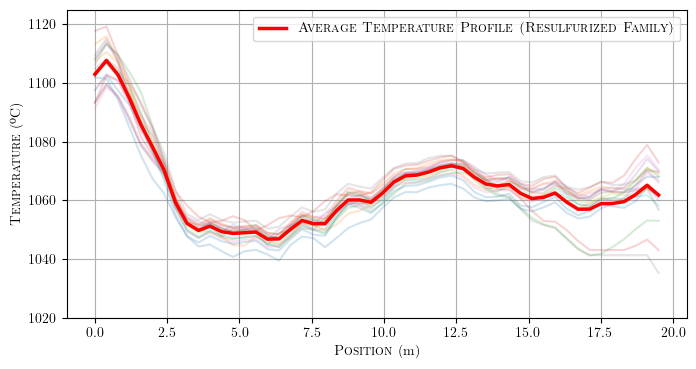

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

# RECORREMOS TODAS LAS PALANQUILLAS DE RESULFURADO
for billet in list(billets_db.keys())[11:29]:
    ax.plot(billets_db[billet]["outputs_ML_reduced"]["posicion"], billets_db[billet]["outputs_ML_reduced"]["temperatura"], alpha = 0.2)
    ax.set_xlabel(r"\textsc{Position} (m)")
    ax.set_ylabel(r"\textsc{Temperature} (ºC)")
    ax.set_ylim(1020, 1125)

example_billet = "6211341"
ax.plot(billets_db[example_billet]["outputs_ML_reduced"]["posicion"], DESIRED_TEMPERATURE_PROFILE, linewidth=2.5, color="red", label=r"\textsc{Average Temperature Profile (Resulfurized Family)}")

ax.legend()
ax.grid()

plt.savefig("DQN-target.png", dpi=1000)

plt.show()

#### **IMPORTACIÓN DEL MODELO DE ML**

In [19]:
#############
# MODELO ML #
#############

MODEL_ML_FURNACE = keras.models.load_model("/home/bolivars/Escritorio/code/3-machine-learning-models/convolutional-recurrent-model/convolutional-recurrent-model-best-performance.h5")

2023-06-22 11:09:25.749334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### **ESPACIO DE ACCIONES**

In [20]:
#######################
# ESPACIO DE ACCIONES #
#######################

ACTION_SPACE = [] # conjunto de las posibles acciones (es preciso discretizar este espacio)

num_rows = 20 # número de steps que se modifican en cada acción
stride = 5 # salto de un instante a otro de la serie temporal multivariante (hay que saltar 5 variables)
action_window = num_rows * stride # número de elementos total que es necesario saltar

oper_quantity = [(0, [0.85, 0.9, 0.01, 1.1, 1.15])]
# oper_quantity = [(0, [0.8, 0.85, 0.9, 1.1, 1.15, 1.2]), (-1, [10, 100]), (1, [10, 100])]

for i in range(0, INITIAL_STATE.shape[0], action_window):
    for k in range(1,5): # en esta primera prueba, solo aplicamos acciones sobre las potencias de los inductores (posiciones 1-4), no tocamos el avance (posición 0)
        for operation, quantities in oper_quantity:
            for quantity in quantities:
                action = (i+k, i+action_window, stride, operation, quantity) # action = (start, stop, step, operation, quantity)
                ACTION_SPACE.append(action) 

ACTION_SPACE_SIZE = len(ACTION_SPACE)

print(f"EL NÚMERO DE ACCIONES CONSIDERADAS SON {ACTION_SPACE_SIZE}.")

EL NÚMERO DE ACCIONES CONSIDERADAS SON 200.


#### **ENTORNO VIRTUAL: SIMULADOR DEL HORNO - MODELO DE ML**

In [21]:
###########
# ENTORNO #
###########

class FurnaceEnvironment:

    # CONSTRUCTOR
    def __init__(self, initial_state, desired_pattern, action_space, model_ml_furnace):
        self.initial_state = initial_state.copy() # estado incial
        self.desired_pattern = desired_pattern.copy() # patrón de temperatura deseado/objetivo
        self.action_space = action_space.copy()
        self.model_ml_furnace = model_ml_furnace
    
    # RESETEAR AL ESTADO INCIAL
    def reset(self):
        self.state = self.initial_state.copy() # el estado tras hacer reset es el estado inicial
        self.episode_step = 0 # tras hacer un reset, el contador de pasos relativo al episodio se pone a cero
        return self.state
    
    # APLICA LA ACCIÓN, RETORNANDO EL NUEVO ESTADO, LA RECOMPENSA Y UN INDICADOR QUE INDICA SI SE ALCANZA EL OBJETIVO
    def step(self, action):

        # INICIALIZACIÓN/ACTUALIZACIÓN DE PARÁMETROS
        self.episode_step += 1 # cada vez que se aplique una acción, aumentamos el contador de los steps del episodio
        done = False # indica si se ha llegado al objetivo

        # ACTUALIZACIÓN DEL ESTADO:
        start, end, step, operation, quantity = self.action_space[action] # selección de la acción     
        positions = np.arange(start, end, step) # posiciones del estado que se van a modificar

        next_state = self.state

        if operation==0:
            next_state[positions] *= quantity
            next_state[positions] = np.minimum(next_state[positions], 1000) # impongo un tope superior de 1000 kW de potencia
        elif operation==1:
            next_state[positions] += quantity
            next_state[positions] = np.minimum(next_state[positions], 1000) # impongo un tope superior de 1000 kW de potencia
        elif operation==-1:
            next_state[positions] -= quantity
            next_state[positions] = np.maximum(next_state[positions], 0) # si obtengo una potencia negativa, la hago cero

        self.state = next_state

        # PREDICCIÓN DEL PERFIL DE TEMPERATURAS ASOCIADO AL NUEVO ESTADO UTILIZANDO EL MODELO DE ML:
        data = np.array(next_state).reshape(200,5).copy()

        # ESTIMAMOS EL CONSUMO ENERGÉTICO DEL NUEVO ESTADO (kWh) [antes de normalizar!]:
        energy_consumption = 1/3600*np.sum(data[:, 1:5]) # se asume que cada potencia se aplica durante un segundo (realmente el time step es un poco mayor, muy poco, pero es una estimación)

        # NORMALIZACIÓN (el modelo de ML trabaja con estados normalizados! Usamos los valores min/max del conjunto de entrenamiento del modelo de ML)
        data[:,0] = (data[:,0]-min_advance)/(max_advance-min_advance)
        data[:,1] = (data[:,1]-min_power_inductor_g1)/(max_power_inductor_g1 - min_power_inductor_g1)
        data[:,2] = (data[:,2]-min_power_inductor_g2)/(max_power_inductor_g2 - min_power_inductor_g2)
        data[:,3] = (data[:,3]-min_power_inductor_g3)/(max_power_inductor_g3 - min_power_inductor_g3)
        data[:,4] = (data[:,4]-min_power_inductor_g4)/(max_power_inductor_g4 - min_power_inductor_g4)

        input_data = np.transpose(data)
        input_data = input_data.reshape((-1, 5, 200), order='C')
        predicted_temp_profile = self.model_ml_furnace.predict(input_data, verbose=0)
        
        # CALCULAMOS LA RECOMPENSA:        
        RMSE = np.sqrt(np.mean((predicted_temp_profile - DESIRED_TEMPERATURE_PROFILE)**2)) # RMSE entre perfiles de temperatura

        CORR = np.corrcoef(DESIRED_TEMPERATURE_PROFILE, predicted_temp_profile)[0,1] # correlación entre perfiles de temperatura

        if RMSE >= 25:
            reward = -1_000_000 - RMSE
        elif 10 <= RMSE and RMSE < 25:
            reward = -10_000 - RMSE
        elif 7 <= RMSE and RMSE < 10:
            reward = -1_000 - RMSE
        elif 5 <= RMSE and RMSE < 7:
            reward = -100 - RMSE
        else:
            reward = (100 - energy_consumption)*CORR

        # CRITERIO DE PARADA: la recompensa es positiva (RMSE<5) y el consumo energético es menor de 10 (inferior al mínimo registrado entre las palanquillas de resulfurado)
        if (reward > 0 and energy_consumption < 10) or self.episode_step >= 100:
            done = True
            
        return self.state, reward, done, energy_consumption, RMSE

In [22]:
#########################
# AGENTE/DEEP Q-NETWORK #
#########################

class DeepQNetwork:

    # CONSTRUCTOR
    def __init__(self, replay_memory_size, min_replay_memory_size, minibatch_size, update_target_every, discount, action_space):

        # INICIALIZAR ALGUNAS VARIABLES
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory_size = min_replay_memory_size
        self.minibatch_size = minibatch_size
        self.update_target_every = update_target_every
        self.discount = discount
        self.action_space = action_space
        
        self.target_update_counter = 0
        self.replay_memory = deque(maxlen=self.replay_memory_size)

        # MODELO PRINCIPAL
        self.model = self.create_model()

        # MODELO OBJETIVO
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())    

    # CONSTRUCTOR DE LA Q-NETWORK
    def create_model(self):

        model = Sequential()
        model.add(keras.layers.Dense(1024, input_shape = STATES_SIZE, activation="relu"))
        model.add(keras.layers.Dense(1024, activation="relu", kernel_initializer=initializers.HeNormal()))
        model.add(keras.layers.Dense(512, activation="relu", kernel_initializer=initializers.HeNormal()))
        model.add(keras.layers.Dense(256, activation="relu", kernel_initializer=initializers.HeNormal()))
        model.add(keras.layers.Dense(len(self.action_space), activation="linear"))
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['mse'])
        
        return model
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    # ENTRENA EL MODELO PRINCIPAL EN CADA PASO DEL EPISODIO
    def train(self, terminal_state, step):

        # El entrenamiento empieza solo si se ha guardado un número mínimo de muestras
        if len(self.replay_memory) < self.min_replay_memory_size:
            return
        
        # Se obtiene un minibatch aleatorio del buffer
        minibatch = random.sample(self.replay_memory, self.minibatch_size)

        # Se obtienen los estados actuales para, a continuación, usar la NN para obtener los Q-values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Se obtienen los estados futuros para, a continuación, usar la NN para obtener los Q-values
        # Si se utiliza el modelo objetivo, hay que consultarla; si no, hay que usar el modelo principal.
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states, verbose = 0)

        X = []
        y = []
        
        # Se enumeran los batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            
            # Si no es un estado terminal, obtener Q-value a partir de los estados futuros.
            # Si es terminal, el Q-value coincide con la recompensa (no hay estados futuros, max_future_q=0)
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + self.discount * max_future_q
            else:
                new_q = reward

            # Se actualizan los Q-values para el estado actual
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # Se añaden a los datos de entrenamiento
            X.append(current_state)
            y.append(current_qs)

        # Se entrena el modelo
        self.model.fit(np.array(X), np.array(y), batch_size=self.minibatch_size, verbose=0, shuffle=False)

        # Se actualiza el contador para el modelo objetivo en cada episodio
        if terminal_state:
            self.target_update_counter += 1

        # Se actualizan los pesos del modelo objetivo (con los del modelo principal) cuando el contador llega al límite establecido
        if self.target_update_counter > self.update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
        
    # Utiliza el modelo principal para hacer una predicción de los Q-values asociados al estado actual
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose = 0)[0]

#### **EJECUCIÓN DEL ALGORITMO DE RL**

In [23]:
############################
# INICIALIZAMOS EL ENTORNO #
############################

env = FurnaceEnvironment(INITIAL_STATE, DESIRED_TEMPERATURE_PROFILE, ACTION_SPACE, MODEL_ML_FURNACE)

In [24]:

###########################
# INICIALIZAMOS EL AGENTE #
###########################

REPLAY_MEMORY_SIZE = 1_000
MIN_REPLAY_MEMORY_SIZE = 64
MINIBATCH_SIZE = 64
UPDATE_TARGET_EVERY = 5
DISCOUNT = 0.7

agent = DeepQNetwork(REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY_SIZE, MINIBATCH_SIZE, UPDATE_TARGET_EVERY, DISCOUNT, ACTION_SPACE)

In [25]:
EPISODES = 500
MODEL_NAME = "deep-q-network-trained-best-performance"
MIN_REWARD = -1_000_000_000

EPSILON = 0.9 # favorecemos la exploración para cubrir todo el espacio de acciones. Conforme avanzamos en el entrenamiento, EPSILON baja y vamos fiándonos más del criterio de la DQN. Inicialmente, toma de decisiones casi aleatoria porque la DQN no ha sido entrenada (pesos aleatorios)
EPSILON_DECAY = 0.975
MIN_EPSILON = 0.3

BEST_STATE = 0*INITIAL_STATE
STATES_WITH_LARGEST_REWARD = []

In [26]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # suprimo warnings

In [27]:
# INICIALIZAR PESOS DEL MODELO CON LOS OBTENIDOS EN EJECUCIONES ANTERIORES

# Uno de los problemas del RL es que tiene un alto coste computacional. Por ejemplo, si se ejecutan 2_000 episodios de golpe (cada uno de ellos tiene 50 steps),
# entonces es equivalente a hacer 100_000 épocas. Una solución es ejecutar 500 episodios para el entrenamiento, evitar que el kernel se interrumpa, y luego
# reutilizar estos pesos para volver a entrenar otro lote de 500 episodios... Y así sucesivamente. Esto es lo que hace esta celda.

from tensorflow.keras.models import load_model

previous_model = load_model('/home/bolivars/Escritorio/code/4-energy-optimization/models_avg_pattern/deep-q-network-trained-best-backup.h5')
previous_weights = previous_model.get_weights()

agent.model.set_weights(previous_weights)
agent.target_model.set_weights(previous_weights)

In [28]:
# ITERAMOS SOBRE LOS EPISODIOS
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # RESET DEL EPISODIO
    episode_reward = 0 # ponemos la recompensa acumulada del episodio a cero
    step = 1
    actions_carried_out = []
    current_state = env.reset() # reset del ESTADO

    done = False # reset del indicador de FIN

    while not done:

        # MÉTODO ÉPSILON-GREEDY PARA ESCOGER UNA ACCIÓN
        if np.random.random() > EPSILON: # explotación
            # Se escoge la acción con mayor Q-value
            action = np.argmax(agent.get_qs(current_state))
        else: # exploración
            # Se escoge una acción de manera aleatoria
            action = np.random.randint(0, len(env.action_space))

        actions_carried_out.append(action)

        # NUEVO ESTADO BASADO EN LA ACCIÓN ESCOGIDA
        new_state, reward, done, energy_consumed, rmse = env.step(action)

        # Se guarda el modelo, pero solo cuando la recompensa es mayor que una dada
        if reward > MIN_REWARD:
            
            env.episode_step -= 10 # para que si va en la dirección correcta dentro de un episodio, no sea un problema el límite de steps
            BEST_STATE = new_state.copy()
            MIN_REWARD = reward
            print(f"MODELO GUARDADO (EPISODE {episode}) - RECOMPENSA: {round(reward,2)} - CONSUMO ENERGÍA: {round(energy_consumed,3)} kWh - RMSE: {round(rmse,2)} ºC - EPSILON: {round(EPSILON,2)}")
            agent.model.save(f'models_avg_pattern/{MODEL_NAME}.h5', overwrite=True)
            STATES_WITH_LARGEST_REWARD.append((BEST_STATE, MIN_REWARD, actions_carried_out))


        episode_reward += reward # actualizamos recompensa acumulada

        # ACTUALIZACIÓN DE LA Q-NETWORK Y ALGUNOS PARÁMETROS
        agent.update_replay_memory((current_state, action, reward, new_state, done)) # actualizamos el buffer
        agent.train(done, step) # entrenamos el modelo principal

        current_state = new_state
        step += 1

    # DISMINUCIÓN DE EPSILON
    if EPSILON > MIN_EPSILON:
        EPSILON *= EPSILON_DECAY
        EPSILON = max(MIN_EPSILON, EPSILON)

  0%|          | 0/500 [00:00<?, ?episodes/s]

MODELO GUARDADO (EPISODE 1) - RECOMPENSA: -10020.83 - CONSUMO ENERGÍA: 15.636 kWh - RMSE: 20.83 ºC - EPSILON: 0.9
MODELO GUARDADO (EPISODE 1) - RECOMPENSA: -10016.31 - CONSUMO ENERGÍA: 12.751 kWh - RMSE: 16.31 ºC - EPSILON: 0.9
MODELO GUARDADO (EPISODE 1) - RECOMPENSA: -10014.36 - CONSUMO ENERGÍA: 10.93 kWh - RMSE: 14.36 ºC - EPSILON: 0.9
MODELO GUARDADO (EPISODE 1) - RECOMPENSA: -10012.94 - CONSUMO ENERGÍA: 11.084 kWh - RMSE: 12.94 ºC - EPSILON: 0.9
MODELO GUARDADO (EPISODE 1) - RECOMPENSA: -10011.86 - CONSUMO ENERGÍA: 10.717 kWh - RMSE: 11.86 ºC - EPSILON: 0.9
MODELO GUARDADO (EPISODE 1) - RECOMPENSA: -10011.54 - CONSUMO ENERGÍA: 10.851 kWh - RMSE: 11.54 ºC - EPSILON: 0.9


  1%|          | 4/500 [00:34<1:08:18,  8.26s/episodes]

MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -1008.3 - CONSUMO ENERGÍA: 13.213 kWh - RMSE: 8.3 ºC - EPSILON: 0.81
MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -1007.85 - CONSUMO ENERGÍA: 10.893 kWh - RMSE: 7.85 ºC - EPSILON: 0.81
MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -106.79 - CONSUMO ENERGÍA: 11.03 kWh - RMSE: 6.79 ºC - EPSILON: 0.81
MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -105.88 - CONSUMO ENERGÍA: 11.18 kWh - RMSE: 5.88 ºC - EPSILON: 0.81
MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -105.61 - CONSUMO ENERGÍA: 11.268 kWh - RMSE: 5.61 ºC - EPSILON: 0.81
MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -105.26 - CONSUMO ENERGÍA: 11.433 kWh - RMSE: 5.26 ºC - EPSILON: 0.81
MODELO GUARDADO (EPISODE 5) - RECOMPENSA: -105.23 - CONSUMO ENERGÍA: 11.431 kWh - RMSE: 5.23 ºC - EPSILON: 0.81


  4%|3         | 18/500 [02:31<1:01:56,  7.71s/episodes]

MODELO GUARDADO (EPISODE 19) - RECOMPENSA: 86.08 - CONSUMO ENERGÍA: 11.983 kWh - RMSE: 4.51 ºC - EPSILON: 0.57
MODELO GUARDADO (EPISODE 19) - RECOMPENSA: 86.08 - CONSUMO ENERGÍA: 11.959 kWh - RMSE: 3.83 ºC - EPSILON: 0.57
MODELO GUARDADO (EPISODE 19) - RECOMPENSA: 86.24 - CONSUMO ENERGÍA: 11.786 kWh - RMSE: 4.3 ºC - EPSILON: 0.57
MODELO GUARDADO (EPISODE 19) - RECOMPENSA: 86.25 - CONSUMO ENERGÍA: 11.626 kWh - RMSE: 4.34 ºC - EPSILON: 0.57
MODELO GUARDADO (EPISODE 19) - RECOMPENSA: 86.27 - CONSUMO ENERGÍA: 11.608 kWh - RMSE: 3.94 ºC - EPSILON: 0.57


 52%|#####1    | 259/500 [35:46<33:15,  8.28s/episodes] 

MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.742 kWh - RMSE: 4.96 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.74 kWh - RMSE: 4.89 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.739 kWh - RMSE: 4.83 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.737 kWh - RMSE: 4.78 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.736 kWh - RMSE: 4.73 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.734 kWh - RMSE: 4.69 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.733 kWh - RMSE: 4.65 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.52 - CONSUMO ENERGÍA: 11.732 kWh - RMSE: 4.61 ºC - EPSILON: 0.3
MODELO GUARDADO (EPISODE 260) - RECOMPENSA: 86.74 - CONSUMO ENERGÍA: 11.559 kWh - RMSE: 4.48 ºC - EPSILON: 0.3
MO

100%|##########| 500/500 [1:09:13<00:00,  8.31s/episodes]


In [38]:
OPTIM_STATE = BEST_STATE.copy()
print(f"La recompensa más alta que se ha obtenido es {MIN_REWARD}.")

La recompensa más alta que se ha obtenido es 87.20176614289109.


In [39]:
SORTED_STATES_WITH_LARGEST_REWARD = sorted(STATES_WITH_LARGEST_REWARD, key=lambda x: -x[1])
print(SORTED_STATES_WITH_LARGEST_REWARD[0][2])

[66, 57, 160, 123, 110, 160, 160, 160, 160, 160, 44, 76, 90, 62, 90, 90, 90, 11, 97, 145, 145, 110, 18, 145, 134, 145, 145, 160, 0, 56, 56, 56, 56, 56, 56, 15, 88, 56, 56, 65, 56, 136, 145, 162, 145, 136, 145, 145, 145, 145, 93, 145, 145, 145, 145, 145, 145, 145, 145, 145, 155, 174, 136, 16, 19, 104, 124, 16, 30]


In [40]:
# CALCULA CONSUMO ENERGÉTICO ASOCIADO A UN ESTADO (UNA CONFIGURACIÓN)
def compute_energy_consumption(state):
    data = np.array(state).reshape(200,5).copy()
    return 1/3600*np.sum(data[:, 1:5])

# PREDICE EL PERFIL DE TEMPERATURA UTILIZANDO EL MODELO DE MACHINE LEARNING
def predict_temp_profile(state):

    data = np.array(state).reshape(200,5).copy()

    # NORMALIZACIÓN (el modelo de ML trabaja con estados normalizados! Usamos los valores min/max del conjunto de entrenamiento del modelo de ML)
    data[:,0] = (data[:,0]-min_advance)/(max_advance-min_advance)
    data[:,1] = (data[:,1]-min_power_inductor_g1)/(max_power_inductor_g1 - min_power_inductor_g1)
    data[:,2] = (data[:,2]-min_power_inductor_g2)/(max_power_inductor_g2 - min_power_inductor_g2)
    data[:,3] = (data[:,3]-min_power_inductor_g3)/(max_power_inductor_g3 - min_power_inductor_g3)
    data[:,4] = (data[:,4]-min_power_inductor_g4)/(max_power_inductor_g4 - min_power_inductor_g4)

    data = np.transpose(data)

    data=data.reshape((-1, 5, 200), order='C')

    outputs = MODEL_ML_FURNACE.predict(data, verbose=0)
    
    return outputs

In [41]:
print(150*"=")
print("***** INFORMACIÓN *****")
print(150*"=")
print("CONSUMO ENERGÉTICO DEL ESTADO INICIAL [PATRÓN CALENTAMIENTO MEDIO - FAMILIA RESULFURADO]:", round(compute_energy_consumption(INITIAL_STATE_BACKUP),3), "kWh.")
print("CONSUMO ENERGÉTICO DEL ESTADO OPTIMIZADO [PERFIL TEMPERATURA MEDIO - FAMILIA RESULFURADO]:", round(compute_energy_consumption(OPTIM_STATE),3), "kWh.")
print("RMSE(INICIAL-OBJETIVO):", round(np.sqrt(np.mean((predict_temp_profile(INITIAL_STATE_BACKUP) - DESIRED_TEMPERATURE_PROFILE_BACKUP)**2)),2), "ºC.")
print("RMSE(OPTIMIZADO-OBJETIVO):", round(np.sqrt(np.mean((predict_temp_profile(OPTIM_STATE) - DESIRED_TEMPERATURE_PROFILE_BACKUP)**2)),2), "ºC.")
print(150*"=")

***** INFORMACIÓN *****
CONSUMO ENERGÉTICO DEL ESTADO INICIAL [PATRÓN CALENTAMIENTO MEDIO - FAMILIA RESULFURADO]: 15.636 kWh.
CONSUMO ENERGÉTICO DEL ESTADO OPTIMIZADO [PERFIL TEMPERATURA MEDIO - FAMILIA RESULFURADO]: 10.764 kWh.
RMSE(INICIAL-OBJETIVO): 20.83 ºC.
RMSE(OPTIMIZADO-OBJETIVO): 4.63 ºC.


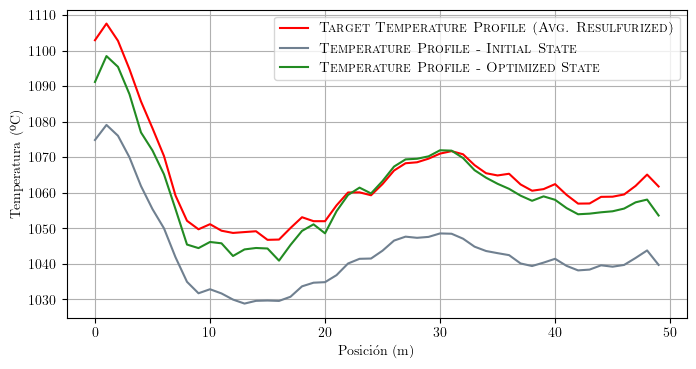

In [42]:
# REPRESENTACIÓN GRÁFICA: ESTADO DESEADO VS. ESTADO INCIAL VS. ESTADO ÓPTIMO
plt.figure(figsize=(8,4))

plt.plot(DESIRED_TEMPERATURE_PROFILE, label=r"\textsc{Target Temperature Profile (Avg. Resulfurized)}", color="red")
plt.plot(np.array(predict_temp_profile(np.array(INITIAL_STATE)).tolist()[0]), label=r"\textsc{Temperature Profile - Initial State}", color="slategrey")
plt.plot(np.array(predict_temp_profile(np.array(OPTIM_STATE).reshape(200,5).copy()).tolist()[0]), label=r"\textsc{Temperature Profile - Optimized State}", color="forestgreen")

plt.grid()
plt.xlabel("Posición (m)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.savefig("comparative-temp-profiles-avg.png", dpi=1000)

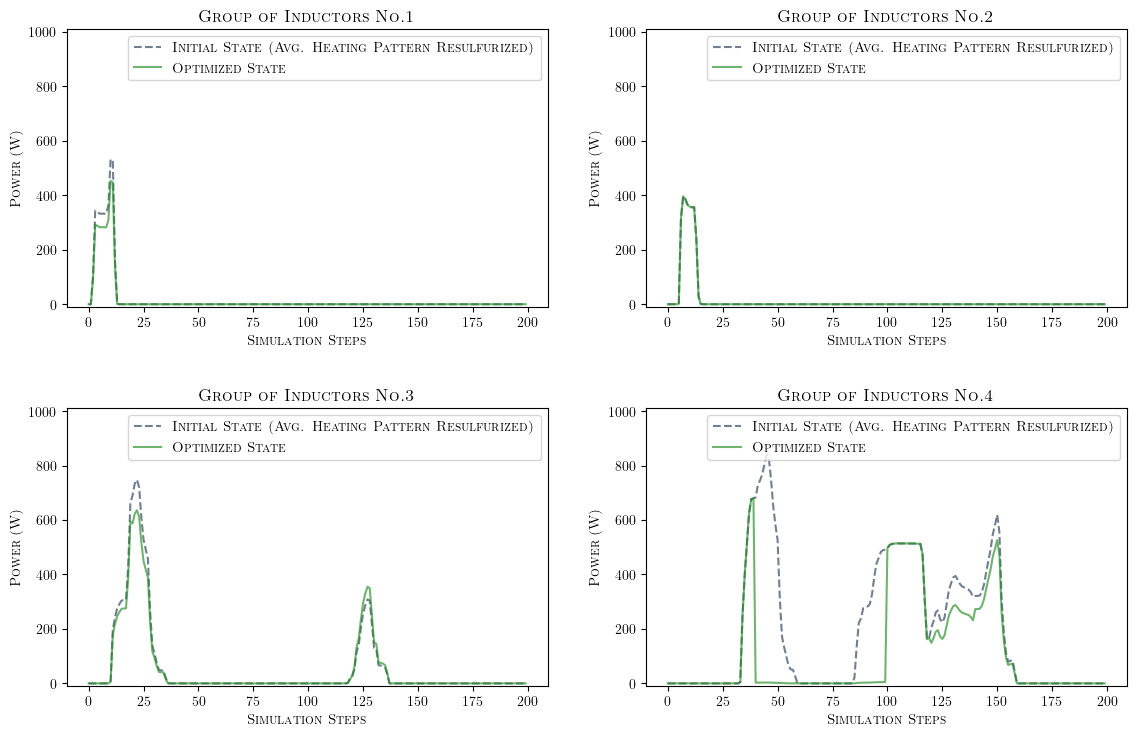

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

optim_state = np.array(OPTIM_STATE).reshape(200,5)
initial_state = INITIAL_STATE.reshape(200,5)

# Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
axes[0, 0].plot(initial_state[:, 1], label=r"\textsc{Initial State (Avg. Heating Pattern Resulfurized)}", color="slategrey", linestyle="--")
axes[0, 0].plot(optim_state[:, 1], label=r"\textsc{Optimized State}", color="forestgreen", alpha = 0.65)
axes[0, 0].set_xlabel(r"\textsc{Simulation Steps}")
axes[0, 0].set_ylabel(r"\textsc{Power (W)}")
axes[0, 0].set_title(r"\textsc{Group of Inductors No.1}")
axes[0, 0].legend()
axes[0, 0].set_ylim(-10, 1010) 

# Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
axes[0, 1].plot(initial_state[:, 2], label=r"\textsc{Initial State (Avg. Heating Pattern Resulfurized)}", color="slategrey", linestyle="--")
axes[0, 1].plot(optim_state[:, 2], label=r"\textsc{Optimized State}", color="forestgreen", alpha = 0.65)
axes[0, 1].set_xlabel(r"\textsc{Simulation Steps}")
axes[0, 1].set_ylabel(r"\textsc{Power (W)}")
axes[0, 1].set_title(r"\textsc{Group of Inductors No.2}")
axes[0, 1].legend()
axes[0, 1].set_ylim(-10, 1010) 

# Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
axes[1, 0].plot(initial_state[:, 3], label=r"\textsc{Initial State (Avg. Heating Pattern Resulfurized)}", color="slategrey", linestyle="--")
axes[1, 0].plot(optim_state[:, 3], label=r"\textsc{Optimized State}", color="forestgreen", alpha = 0.65)
axes[1, 0].set_xlabel(r"\textsc{Simulation Steps}")
axes[1, 0].set_ylabel(r"\textsc{Power (W)}")
axes[1, 0].set_title(r"\textsc{Group of Inductors No.3}")
axes[1, 0].legend()
axes[1, 0].set_ylim(-10, 1010) 

# Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
axes[1, 1].plot(initial_state[:, 4], label=r"\textsc{Initial State (Avg. Heating Pattern Resulfurized)}", color="slategrey", linestyle="--")
axes[1, 1].plot(optim_state[:, 4], label=r"\textsc{Optimized State}", color="forestgreen", alpha = 0.65)
axes[1, 1].set_xlabel(r"\textsc{Simulation Steps}")
axes[1, 1].set_ylabel(r"\textsc{Power (W)}")
axes[1, 1].set_title(r"\textsc{Group of Inductors No.4}")
axes[1, 1].legend()
axes[1, 1].set_ylim(-10, 1010)  

plt.tight_layout(pad=3.0)
plt.savefig("optimized-heating-pattern-avg.png", dpi=1000)
plt.show()